In [2]:
# importando modulos necesarios
import numpy as np
import pandas as pd
#mport pandas.io.data as web
import datetime as dt
#rom pydataset import data
import statsmodels.api as sm 

# librerías de visualizaciones
import seaborn as sns
import matplotlib.pyplot as plt 


# graficos incrustados
%matplotlib inline

# pandas solo 4 decimales
pd.set_option('precision', 4)

In [ ]:
!pip install skforecast

In [ ]:
!pip install yfinance

In [4]:
#predicciones



from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [5]:
import yfinance as yf

Siglas:AC
[*********************100%***********************]  1 of 1 completed


Text(0.5, 1.0, 'Valor de la acción período enero 2016 a oct 2022')

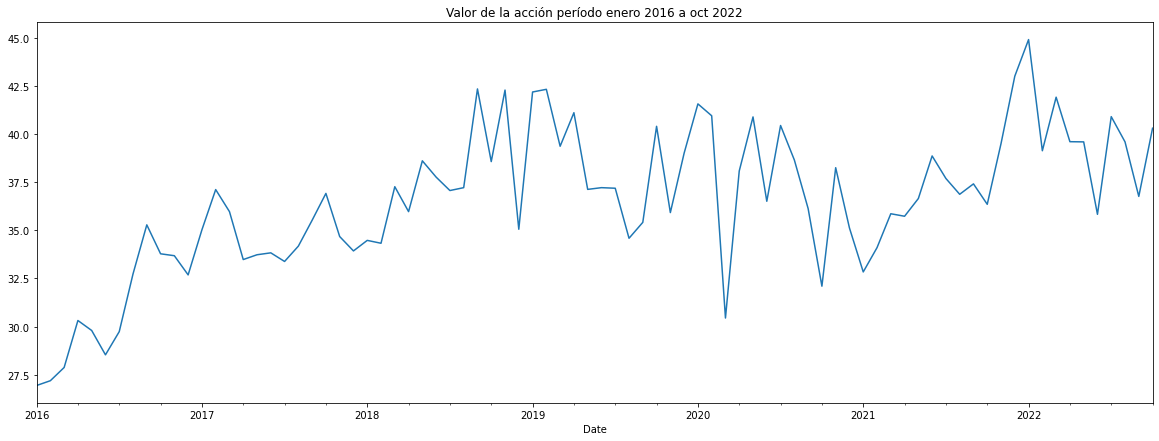

In [11]:
start = '2016-01-01'
end = '2022-10-22'
sigla = input('Siglas:')
sigla = yf.download(sigla, start, end, interval = "1mo")

# Crea un gráfico con los valores de la acción: 
sigla['Close'].plot(label = 'Acción', figsize = (20,7)) 
plt.title('Valor de la acción período enero 2016 a oct 2022')

In [12]:
df =sigla
df.reset_index(inplace=True)


In [13]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-01-01,29.8408,30.2488,25.3930,26.9453,25.9871,343305.0
1,2016-02-01,27.6537,29.3134,24.5473,27.1940,26.2270,481791.0
2,2016-03-01,27.2935,28.6567,27.0149,27.8806,26.8891,331646.0
3,2016-04-01,27.6119,30.7264,27.4428,30.3184,29.2402,509329.0
4,2016-05-01,30.6169,30.7363,29.5124,29.8010,28.7412,425112.0


In [14]:
#gráfico estacional de una serie temporal
# etiquetas por año
df['year'] = [d.year for d in df.Date]
df['month'] = [d.strftime('%b') for d in df.Date]
df['day'] = [d.day for d in df.Date]
years = df['year'].unique()
df

,Date,Open,High,Low,Close,Adj Close,Volume,year,month,day
0,2016-01-01,29.8408,30.2488,25.3930,26.9453,25.9871,343305.0,2016,Jan,1
1,2016-02-01,27.6537,29.3134,24.5473,27.1940,26.2270,481791.0,2016,Feb,1
2,2016-03-01,27.2935,28.6567,27.0149,27.8806,26.8891,331646.0,2016,Mar,1
3,2016-04-01,27.6119,30.7264,27.4428,30.3184,29.2402,509329.0,2016,Apr,1
4,2016-05-01,30.6169,30.7363,29.5124,29.8010,28.7412,425112.0,2016,May,1
...,...,...,...,...,...,...,...,...,...,...
77,2022-06-01,39.2900,41.6400,33.6900,35.8300,35.7317,272600.0,2022,Jun,1
78,2022-07-01,36.0000,43.3900,35.4900,40.9000,40.9000,106000.0,2022,Jul,1
79,2022-08-01,41.0000,44.5000,38.4600,39.5900,39.5900,88900.0,2022,Aug,1
80,2022-09-01,38.1600,41.3500,35.4400,36.7600,36.7600,107100.0,2022,Sep,1


In [16]:
import plotly.express as px

fig1 = px.line(df, x='year', y='Close', color='month', markers=True  , title='Arca Continental')
fig1.show()


In [17]:
# Aplicando el filtro Hodrick-Prescott para separar en tendencia y 
# componente ciclico.
df_ciclo, df_tend = sm.tsa.filters.hpfilter(df['Close'])
df['tend'] = df_tend
df['ciclo']= df_ciclo

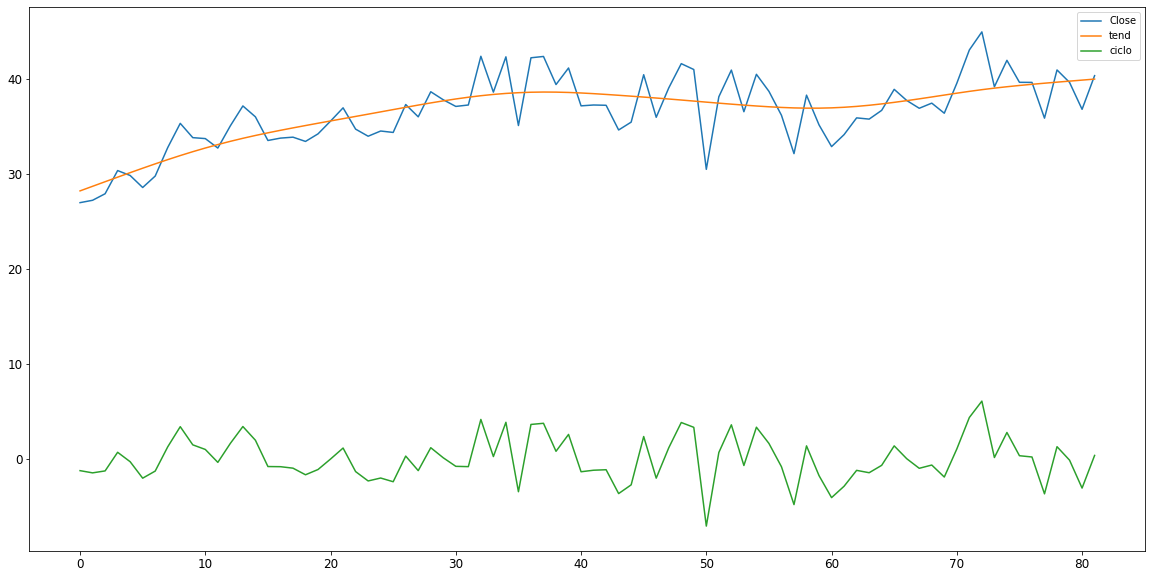

In [18]:
# graficando la variacion del precio real con la tendencia.
df[['Close', 'tend','ciclo']].plot(figsize=(20, 10), fontsize=12);
legend = plt.legend()
legend.prop.set_size(20);

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning:

the 'freq'' keyword is deprecated, use 'period' instead



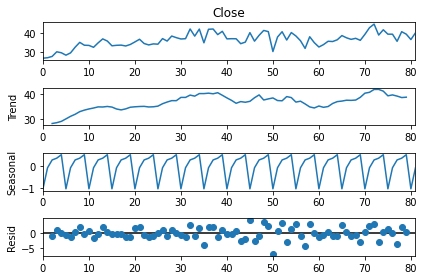

In [19]:
# Ejemplo de descomposición de serie de tiempo
descomposicion = sm.tsa.seasonal_decompose(df['Close'],
                                                  model='additive', period=5)  
fig = descomposicion.plot()

Fechas train : 0 --- 51  (n=52)
Fechas test  : 52 --- 81  (n=30)


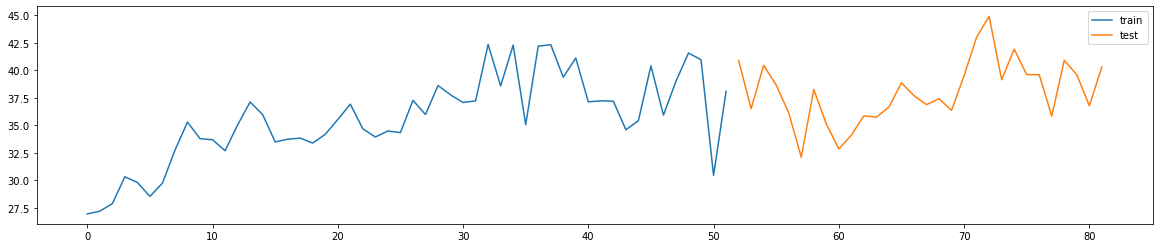

In [21]:
#Se utilizan los últimos 30 meses como conjunto de test para evaluar la capacidad predictiva del modelo.
# Separación datos train-test
# ==============================================================================
steps = 30
datos_train = df[:-steps]
datos_test  = df[-steps:]

print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

fig, ax = plt.subplots(figsize=(20, 4))
datos_train['Close'].plot(ax=ax, label='train')
datos_test['Close'].plot(ax=ax, label='test')
ax.legend();

In [22]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 10 #Utiliza los 10 meses anteriores como predictores (10 rezagos)
             )

forecaster.fit(y=datos_train['Close'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10] 
Transformer for y: None 
Transformer for exog: None 
Window size: 10 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [0, 51] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-11-15 20:56:03 
Last fit date: 2022-11-15 20:56:03 
Skforecast version: 0.5.1 
Python version: 3.7.15 

In [23]:
# Predicciones, datos de prueba (40 meses a futuro)
# ==============================================================================
steps = 40
predicciones = forecaster.predict(steps=steps)
predicciones

52    37.8007
53    38.3005
54    36.9530
55    38.1330
56    37.9575
57    38.3755
58    37.9812
59    40.0562
60    38.4508
61    40.3289
62    38.5464
63    40.3244
64    39.0702
65    39.4652
66    39.1813
67    38.6573
68    38.9695
69    38.2535
70    38.6182
71    38.2269
72    38.4844
73    38.7925
74    38.8070
75    39.0698
76    39.3537
77    39.3059
78    39.3699
79    39.3771
80    39.1355
81    38.5934
82    38.5386
83    38.2327
84    38.3262
85    38.4306
86    38.5633
87    38.8699
88    38.9461
89    39.3970
90    39.4050
91    39.4172
Name: pred, dtype: float64

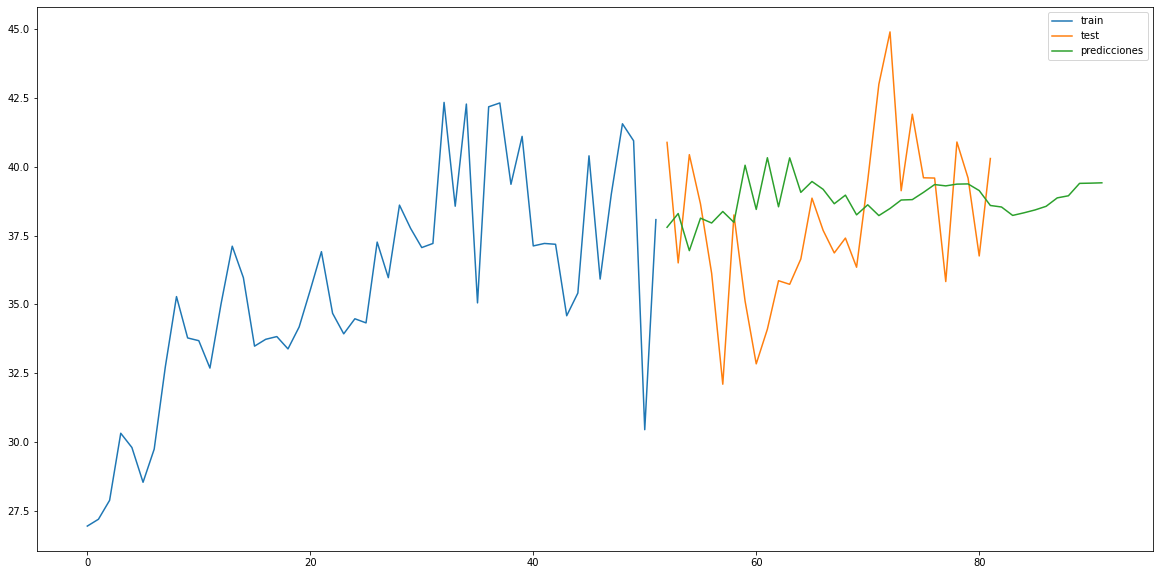

In [24]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(20, 10))
datos_train['Close'].plot(ax=ax, label='train')
datos_test['Close'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();